Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [2]:
#!pip install Partial State

In [1]:
import transformers
print (transformers.__version__)

4.31.0


In [2]:
from transformers import AutoModel, BertTokenizerFast, BertConfig, BertModel

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [4]:
from sparse_grad2 import replace_bert_layers

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [5]:
def create_space_matrices(model):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        
        layer.intermediate.dense.create_UV()
          
        layer.output.dense.create_UV()
          
        #print ("new shape", layer.output.dense.weight.shape)
        #print ("\n\n")

    return model

In [6]:
def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [7]:
from datasets import load_dataset
import pandas as pd

dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [8]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [9]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [10]:
set(pd.DataFrame(dataset_cola['train']).label)

{0, 1}

In [11]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [12]:
#model=model.to('cuda:2')

In [13]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [14]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [15]:
num_labels

2

In [16]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [17]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [18]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [19]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-07-29 19:49:40.598339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [20]:
metric = ev.load("glue", 'cola')

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [23]:
training_args = TrainingArguments(
    learning_rate=5e-5,
    skip_memory_metrics = False,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [24]:
import torch 

from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

class TrainerBert1(Trainer):
    
    def make_grad_bank(self):
        self.n_show = 3
        self.losses = []
    
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        for layer in range(12):
                
            if False:#(model.bert.encoder.layer[layer].output.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].output.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].output.dense.weight.grad
                model.bert.encoder.layer[layer].output.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))

            if False:#(model.bert.encoder.layer[layer].intermediate.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].intermediate.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].intermediate.dense.weight.grad
                model.bert.encoder.layer[layer].intermediate.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))
                

            else:
                
                if (self.n_show > 0):
                    self.n_show -= 1
                    im= plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].output.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show))
                    plt.colorbar(im) #not in spy
                    plt.show()
                    #plt.colorbar(im2)
                    #plt.show()
                    #plt.colorbar(im3)
                    #plt.show()
                    #plt.colorbar(im4)
                    #plt.show()
                    #plt.colorbar(im5)
                    plt.show()

                    im= plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()
                
                    
        
        

        self.losses.append(loss.cpu().detach().numpy())
        return loss.detach()

In [25]:
#model = sparse_grad_linear(model)

In [26]:
trainer = TrainerBert1(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()

KeyboardInterrupt: 

In [ ]:
trainer.train_dataset

## BERT regular

len small dataset 8551
lets collect gradients
number of nonzero  tensor(2359296)


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


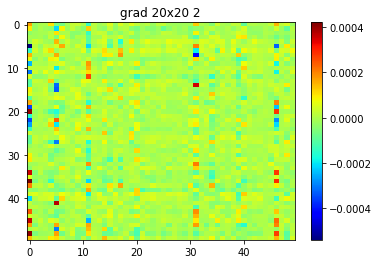

number of nonzero  tensor(2359296)


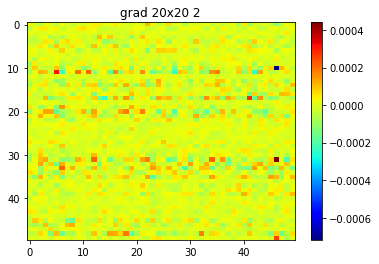

number of nonzero  tensor(2359296)


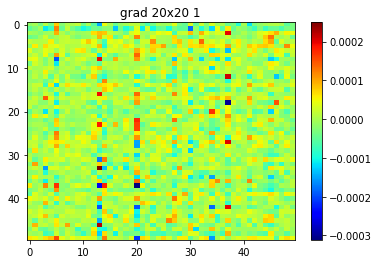

number of nonzero  tensor(2359296)


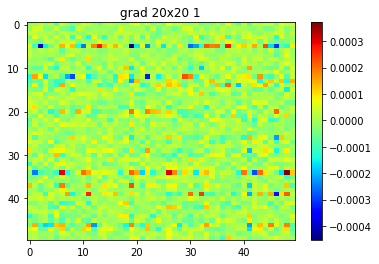

number of nonzero  tensor(2359296)


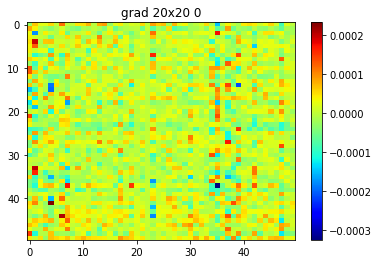

number of nonzero  tensor(2359296)


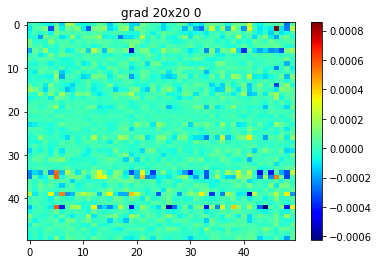

Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.534899,0.395218,0.395218
200,No log,0.578482,0.296116,0.296116
300,No log,0.495487,0.432629,0.432629
400,No log,0.434240,0.517280,0.517280
500,0.494700,0.467093,0.507304,0.507304


finishing collecting gradients


In [28]:

print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [61]:
trainer.evaluate()

{'eval_loss': 0.47498396039009094,
 'eval_matthews_correlation': 0.5153742778418894,
 'eval_combined_score': 0.5153742778418894,
 'eval_runtime': 1.6783,
 'eval_samples_per_second': 621.46,
 'eval_steps_per_second': 5.363,
 'epoch': 1.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 20480,
 'eval_mem_gpu_peaked_delta': 554128896}

In [29]:
trainer.log_metrics("train", train_result.metrics)

***** train metrics *****
  before_init_mem_cpu        =     1202MB
  before_init_mem_gpu        =        0MB
  epoch                      =        1.0
  init_mem_cpu_alloc_delta   =     4860MB
  init_mem_cpu_peaked_delta  =      305MB
  init_mem_gpu_alloc_delta   =      418MB
  init_mem_gpu_peaked_delta  =        0MB
  total_flos                 =   523836GF
  train_loss                 =     0.4919
  train_mem_cpu_alloc_delta  =       78MB
  train_mem_cpu_peaked_delta =        0MB
  train_mem_gpu_alloc_delta  =     1283MB
  train_mem_gpu_peaked_delta =     1709MB
  train_runtime              = 0:01:21.17
  train_samples_per_second   =    105.339
  train_steps_per_second     =      6.591


In [63]:
train_result

TrainOutput(global_step=535, training_loss=0.5029874694681613, metrics={'train_runtime': 81.3044, 'train_samples_per_second': 105.173, 'train_steps_per_second': 6.58, 'total_flos': 562465658595840.0, 'train_loss': 0.5029874694681613, 'init_mem_cpu_alloc_delta': -96387072, 'init_mem_gpu_alloc_delta': 438552064, 'init_mem_cpu_peaked_delta': 96387072, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 7630848, 'train_mem_gpu_alloc_delta': 1345517056, 'train_mem_cpu_peaked_delta': 12288, 'train_mem_gpu_peaked_delta': 1792460288, 'before_init_mem_cpu': 7125512192, 'before_init_mem_gpu': 1784592384, 'epoch': 1.0})

In [30]:
torch.cuda.max_memory_allocated('cuda')

3577577984

**sparse matrix**

In [1]:
from sparse_grad_matrix_spare_mult import replace_bert_layers

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [28]:
from trainers_custom import TrainerBert1, TrainerBert2

In [36]:
import torch
torch.cuda.reset_peak_memory_stats(device=trainer.model.device)
torch.cuda.reset_max_memory_cached(device=trainer.model.device)

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/torch/cuda/memory.py:297: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [33]:
training_args1 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=100,
    max_steps = 31,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

training_args2 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    skip_memory_metrics = False,
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [31]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [34]:
trainer = TrainerBert1(
        model=model,
        args=training_args1,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()

In [35]:
trainer.model.device

device(type='cuda', index=0)

In [70]:
model.bert.encoder.layer[0].intermediate.dense.len_grads

0

In [37]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

len small dataset 8551
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
finishing collecting gradients


In [38]:
torch.cuda.reset_peak_memory_stats()

In [39]:
trainer = TrainerBert2(
        model=model,
        args=training_args2,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()

number of nonzero  tensor(3072)


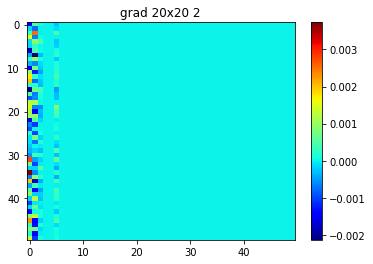

number of nonzero  tensor(15360)


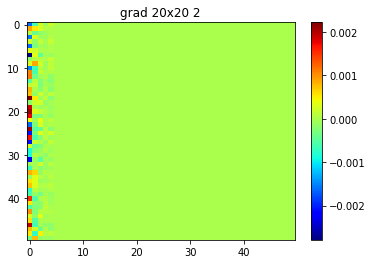

number of nonzero  tensor(2304)


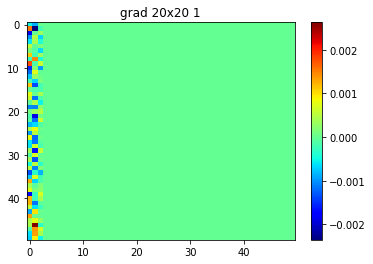

number of nonzero  tensor(12288)


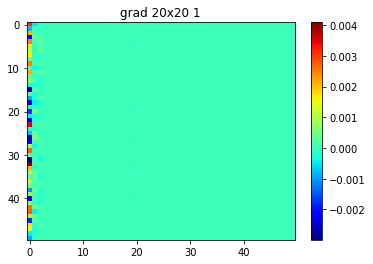

number of nonzero  tensor(2304)


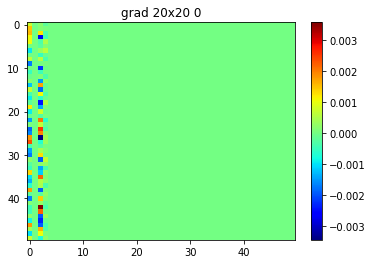

number of nonzero  tensor(9216)


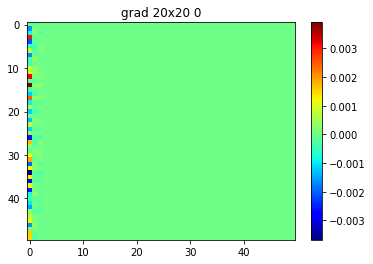

Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.619354,0.000000,0.000000
200,No log,0.617536,0.000000,0.000000
300,No log,0.617947,0.000000,0.000000
400,No log,0.614829,0.000000,0.000000
500,0.615100,0.617764,0.000000,0.000000


In [40]:
train_result = trainer.train()

In [41]:
trainer.evaluate()

{'eval_loss': 0.6164574027061462,
 'eval_matthews_correlation': 0.0,
 'eval_combined_score': 0.0,
 'eval_runtime': 55.5006,
 'eval_samples_per_second': 18.793,
 'eval_steps_per_second': 0.162,
 'epoch': 1.0,
 'eval_mem_cpu_alloc_delta': 21090304,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 1038581760,
 'eval_mem_gpu_peaked_delta': 3569254400}

In [32]:
trainer.log_metrics("train", train_result.metrics)

***** train metrics *****
  before_init_mem_cpu        =     6136MB
  before_init_mem_gpu        =     9542MB
  epoch                      =        1.0
  init_mem_cpu_alloc_delta   =        0MB
  init_mem_cpu_peaked_delta  =        0MB
  init_mem_gpu_alloc_delta   =        0MB
  init_mem_gpu_peaked_delta  =        0MB
  total_flos                 =   523836GF
  train_loss                 =     0.6144
  train_mem_cpu_alloc_delta  =       37MB
  train_mem_cpu_peaked_delta =     1148MB
  train_mem_gpu_alloc_delta  =      852MB
  train_mem_gpu_peaked_delta =     3403MB
  train_runtime              = 0:07:52.69
  train_samples_per_second   =      18.09
  train_steps_per_second     =      1.132


In [32]:
trainer.log_metrics("train", train_result.metrics)

***** train metrics *****
  before_init_mem_cpu        =     1197MB
  before_init_mem_gpu        =        0MB
  epoch                      =        1.0
  init_mem_cpu_alloc_delta   =     4866MB
  init_mem_cpu_peaked_delta  =      305MB
  init_mem_gpu_alloc_delta   =      418MB
  init_mem_gpu_peaked_delta  =        0MB
  total_flos                 =   523836GF
  train_loss                 =     0.4949
  train_mem_cpu_alloc_delta  =       87MB
  train_mem_cpu_peaked_delta =        0MB
  train_mem_gpu_alloc_delta  =     1283MB
  train_mem_gpu_peaked_delta =     1709MB
  train_runtime              = 0:01:16.09
  train_samples_per_second   =    112.379
  train_steps_per_second     =      7.031
